In [1]:
########## import packages ##########

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LassoLarsIC, LinearRegression, LassoCV, LassoLarsCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [116]:
########## functions from python file ##########

# inputs: excess returns dataframe, method, start row and end row number (inclusive rows), and mode
# output: predicted values and coefficients (or intercepts and coefficients)
# runs ols post lasso regression on the data and returns predicted value on the next time period
def OLSlassoRegression(df, method="aic", startRow = 0, endRow = 684, mode="fit"): 
    indNames = list(df.iloc[:, 1:])
    #dataframes to contain betas and predicted values
    lassoResults = pd.DataFrame(np.zeros((len(indNames), len(indNames))), columns = indNames, index = indNames)
    intercepts = pd.DataFrame(np.zeros(len(indNames)), columns = ["Intercept"])
    out = pd.DataFrame(np.zeros(len(indNames)), columns = ["yPred"], index = indNames)
    dfSliced = df.iloc[startRow:endRow + 1, 1:] # no date
    for indIndex in range(len(indNames)):
        X = dfSliced.iloc[:-1, :] 
        y = dfSliced.iloc[1:, indIndex] 
        lasso = lassoM(X, y, method)
        xIndex = np.nonzero(lasso.coef_)[0]
        Xlin = X[X.columns[xIndex]]
        if len(xIndex) > 0:
            ols = linearM(Xlin, y)
            j = 0
            intercepts.iloc[indIndex, 0] = ols.intercept_
            for i in xIndex:
                lassoResults.iloc[indIndex, i] = ols.coef_[j]
                j += 1
            if mode == "predict":
                Xnew = [df.iloc[endRow + 1, xIndex + 1]] # shift selected predictors by 1 columns (date)
                out.iloc[indIndex, 0] = ols.predict(Xnew)[0]
        # no x variables selected, then change later to mean of cross section returns
        else: 
            out.iloc[indIndex, 0] = np.nan
    return (out, lassoResults) if mode == "predict" else (intercepts, lassoResults)

# inputs: excess returns dataframe, method, start row and end row number (inclusive rows), and mode
# output: predicted values and coefficients (or intercepts and coefficients)
# runs ols regression on the data and returns predicted value on the next time period
def OLSRegression(df, method="aic", startRow = 0, endRow = 684, mode="fit"):
    indNames = list(df.iloc[:, 1:])
    #dataframes to contain betas and predicted values
    betas = pd.DataFrame(np.zeros((len(indNames), len(indNames))), columns = indNames, index = indNames)
    intercepts = pd.DataFrame(np.zeros(len(indNames)), columns = ["Intercept"])
    out = pd.DataFrame(np.zeros(len(indNames)), columns = ["yPred"], index = indNames)
    dfSliced = df.iloc[startRow:endRow + 1, 1:] # no date

    for indIndex in range(len(indNames)):
        X = dfSliced.iloc[:-1, :] 
        y = dfSliced.iloc[1:, indIndex] 
        ols = linearM(X, y)
        j = 0
        intercepts.iloc[indIndex, 0] = ols.intercept_
        for i in range(len(indNames)):
            betas.iloc[indIndex, i] = ols.coef_[j]
            j += 1
        if mode == "predict":
            Xnew = [df.iloc[endRow + 1, 1:]] # shift selected predictors by 1 columns (date)
            out.iloc[indIndex, 0] = ols.predict(Xnew)[0]
    return (out, betas) if mode == "predict" else (intercepts, betas)

# inputs: paths to industry returns and risk free rate, beginning date and end date
# output: industry and risk free dataframes (in percentages)
# loads data
def loadData(indPath, rfPath, begDate, endDate):
    #read in data
    ind = pd.read_csv(indPath, skiprows = 11)
    rf = pd.read_csv(rfPath)
    rf.dateff = rf.dateff // 100
    #rename column
    ind.rename(columns={'Unnamed: 0':'Date'}, inplace=True )
    #only select certain dates 
    rf = rf.loc[(rf["dateff"] >= int(begDate)) & (rf["dateff"] <= int(endDate))]
    startRow = (ind[ind.Date == begDate].index)[0]
    endRow = (ind[ind.Date == endDate].index)[0]
    ind = ind.iloc[startRow:endRow + 1]
    ind = ind.reset_index(drop=True)
    rf = rf.reset_index(drop=True)
    indNames = list(ind)
    #convert returns to float and year to int
    ind[indNames[1:]] = ind[indNames[1:]].astype(float)

    ind[indNames[0]] = ind[indNames[0]].astype(int)
    rf["rf"] = rf["rf"] * 100 #all returns in percentages
    return (ind, rf)

# inputs: industry returns and risk free rate dataframes
# output: excess returns dataframe 
# calculates excess returns from raw data
def excessReturns(ind, rf):
    exsReturns = ind.copy()
    indNames = list(ind)
    for i in range(1, len(indNames)):
        exsReturns.iloc[:, i] = ind.iloc[:, i] - rf.iloc[:, 1]
    return exsReturns

# input: excess returns dataframe
# output: dataframe containing summary statistics
# creates summary statistics table (table 1 in research paper)
def summaryStat(exsReturns):
    #create new dataframe to hold summary statistics
    resNames = ["Ann mean", "Ann vol", "Minimum", "Maximum", "Ann Sharpe"]
    res = pd.DataFrame(columns = resNames)
    #ann mean, vol, min, max, sharpe
    res.iloc[:, 0] = np.mean(exsReturns, axis=0) * 12
    res.iloc[:, 1] = (np.std(exsReturns, axis=0) * (12 ** 0.5))
    res.iloc[:, 2] = np.amin(exsReturns, axis=0)
    res.iloc[:, 3] = np.amax(exsReturns, axis=0)
    res.iloc[:, 4] = res.iloc[:, 0] / res.iloc[:, 1]
    return res

# input: X and y values, and method
# output: lasso object
def lassoM(X, y, method):
    if (method == "aic") or (method == "bic"):
        lasso = LassoLarsIC(criterion = method, normalize = True)
        lasso.fit(X, y)
    elif method == "LassoCV": 
        lasso = LassoCV(cv = 20).fit(X, y)
    elif method == "LassoLarsCV": 
        lasso = LassoLarsCV(cv = 20).fit(X, y)
    return lasso

# input: X and y values
# output: linear regression object
def linearM(X, y):
    lin = LinearRegression()
    lin.fit(X, y)
    return lin

In [117]:
########## read in data ##########

indPath = "30_Industry_Portfolios.CSV"
rfPath = "rf.csv"
begDate = "195912"
endDate = "201612"
(ind, rf) = loadData(indPath, rfPath, begDate, endDate)
exsReturns = excessReturns(ind, rf) 
nrow = rf.count()[0]

#create summary table (table 1 in paper)
sumTable = summaryStat(exsReturns.iloc[:, 1:]) # no date
print(sumTable)

        Ann mean    Ann vol  Minimum  Maximum  Ann Sharpe
Food    8.288584  15.022567   -18.15    19.89    0.551742
Beer    8.527358  17.620146   -20.19    25.51    0.483955
Smoke  11.787854  20.982604   -25.32    32.38    0.561792
Games   8.420496  24.857267   -33.40    34.52    0.338754
Books   6.339328  20.109360   -26.56    33.13    0.315243
Hshld   6.650277  16.476647   -22.24    18.22    0.403618
Clths   8.033518  22.105695   -31.50    31.79    0.363414
Hlth    7.810861  17.058878   -21.06    29.01    0.457877
Chems   6.237372  19.102606   -28.60    21.68    0.326519
Txtls   8.008993  24.309069   -33.11    59.03    0.329465
Cnstr   6.281518  20.739503   -28.74    25.02    0.302877
Steel   3.543591  25.254249   -32.99    30.36    0.140317
FabPr   6.751007  21.164538   -31.63    22.91    0.318977
ElcEq   8.450628  21.501609   -32.80    23.21    0.393023
Autos   5.447825  23.154738   -36.49    49.56    0.235279
Carry   8.624759  21.783186   -31.10    23.39    0.395937
Mines   6.5838

In [123]:
########## OLS post Lasso with entire time period ##########

indNames = list(exsReturns.iloc[:, 1:])
df = exsReturns
(inter, fullPeriodResult)= OLSlassoRegression(df) # use aic

In [119]:
########## expanding period L/S portfolio construction ##########

startRow = 0
endRow = df.loc[df["Date"] == 196912].index[0] #start before the first prediction date (paper uses 196912)
lastRow = df.loc[df["Date"] == 201612].index[0]

# start with first predicting row
dateIndex = pd.period_range(start = pd.Period(str(df.loc[endRow + 1, "Date"]), freq = "M"), 
                            end = pd.Period(str(df.loc[lastRow, "Date"]), freq = "M"), freq = "M") 

# dataframes to contain return for each time period for ols post lasso, ols, and prevailing mean
periodR = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)
periodRLin = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)
periodRPM = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)

indBeta = pd.DataFrame(np.zeros((lastRow - endRow, len(indNames))), index = dateIndex, columns = indNames) 
ind = 0 # food

for e in range(endRow, lastRow):
    #OLS POST LASSO OUTPUTS
    (yPred, betas) = OLSlassoRegression(df, startRow = startRow, endRow = e, mode="predict")
    # change not predicted returns to mean of cross section returns
    yPred.loc[np.isnan(yPred)["yPred"], :] = np.nanmean(yPred, axis = 0)
    yPred.sort_values(by = ["yPred"], ascending = True, inplace = True)
    bottomInd = yPred.iloc[:6, :].index #find the industries
    topInd = yPred.iloc[-6:, :].index
    bottomR = df.loc[e + 1, bottomInd] #get the realized returns
    topR = df.loc[e + 1, topInd]
    
    print(indBeta.index[e - endRow], np.round(np.average(topR), 2), np.round(np.average(bottomR), 2), np.round(np.average(topR) - np.average(bottomR), 2))
    periodR.iloc[e - endRow, :] = np.mean(topR) - np.mean(bottomR)
    indBeta.iloc[e - endRow, :] = betas.loc[betas.index[ind], :]
    
    #LINEAR MODEL OUTPUTS
    (yPredLin, betasLin) = OLSRegression(df, startRow = startRow, endRow = e, mode="predict")
    yPredLin.sort_values(by = ["yPred"], ascending = True, inplace = True)
    bottomIndLin = yPredLin.iloc[:6, :].index #find the industries
    topIndLin = yPredLin.iloc[-6:, :].index
    bottomRLin = df.loc[e + 1, bottomIndLin] #get the realized returns
    topRLin = df.loc[e + 1, topIndLin]
    periodRLin.iloc[e - endRow, :] = np.mean(topRLin) - np.mean(bottomRLin)
    
    #PREVAILING MEAN OUPUTS
    X = df.iloc[startRow:e + 1, 1:]
    yPredPM = np.mean(X, axis = 0)
    yPredPM.sort_values(ascending = True, inplace = True)
    bottomIndPM = yPredPM[:6].index #find the industries
    topIndPM = yPredLin.iloc[-6:, :].index
    bottomRPM = df.loc[e + 1, bottomIndPM] #get the realized returns
    topRPM = df.loc[e + 1, topIndPM]
    periodRPM.iloc[e - endRow, :] = np.mean(topRPM) - np.mean(bottomRPM)


1970-01 -6.36 -6.76 0.4
1970-02 5.77 7.06 -1.29
1970-03 -3.15 -2.95 -0.19
1970-04 -11.09 -17.37 6.28
1970-05 -8.28 -11.4 3.13
1970-06 -5.65 -8.67 3.02
1970-07 7.54 4.84 2.71
1970-08 5.22 3.23 2.0
1970-09 10.17 4.59 5.59
1970-10 -3.11 -4.87 1.76
1970-11 1.6 2.81 -1.21
1970-12 8.56 6.35 2.2
1971-01 11.36 5.46 5.9
1971-02 4.1 1.36 2.74
1971-03 6.6 3.82 2.78
1971-04 3.2 6.13 -2.93
1971-05 -2.55 -3.26 0.71
1971-06 0.37 -2.07 2.44
1971-07 -5.11 -5.37 0.26
1971-08 5.12 6.37 -1.25
1971-09 -1.16 -1.98 0.82
1971-10 -3.88 -5.04 1.16
1971-11 -1.24 -2.29 1.04
1971-12 12.48 10.89 1.59
1972-01 7.26 3.89 3.37
1972-02 4.7 3.34 1.37
1972-03 0.73 0.28 0.45
1972-04 1.97 0.34 1.63
1972-05 2.1 0.3 1.8
1972-06 -0.3 -4.4 4.1
1972-07 -1.93 -4.94 3.01
1972-08 2.53 0.75 1.78
1972-09 -0.86 -3.36 2.5
1972-10 1.47 -0.89 2.36
1972-11 7.46 5.52 1.94
1972-12 1.44 -0.83 2.28
1973-01 -3.3 -8.13 4.83
1973-02 -1.91 -8.41 6.5
1973-03 -1.6 -0.89 -0.71
1973-04 -4.23 -11.02 6.78
1973-05 -0.64 -7.06 6.42
1973-06 -2.16 -7.34 5.

1998-10 8.46 4.7 3.76
1998-11 3.84 2.3 1.55
1998-12 2.38 -0.4 2.78
1999-01 1.47 4.71 -3.24
1999-02 -0.72 -2.94 2.22
1999-03 2.9 -0.04 2.94
1999-04 15.36 2.58 12.79
1999-05 1.48 -6.33 7.81
1999-06 2.22 5.02 -2.8
1999-07 -2.94 -4.64 1.71
1999-08 -0.01 -6.0 5.98
1999-09 -6.24 -1.9 -4.34
1999-10 6.86 -4.7 11.56
1999-11 -2.02 1.83 -3.85
1999-12 11.61 -1.73 13.34
2000-01 -2.25 -6.17 3.91
2000-02 1.43 -8.14 9.57
2000-03 8.94 8.31 0.63
2000-04 1.27 -5.13 6.39
2000-05 7.78 -7.16 14.93
2000-06 2.31 -3.71 6.02
2000-07 -2.43 1.76 -4.19
2000-08 8.16 -2.74 10.9
2000-09 -5.49 -7.69 2.2
2000-10 2.41 -1.39 3.8
2000-11 -3.54 -0.24 -3.3
2000-12 4.54 7.49 -2.95
2001-01 10.32 -3.77 14.1
2001-02 -7.22 -4.49 -2.73
2001-03 -1.43 -6.93 5.5
2001-04 7.96 6.62 1.34
2001-05 3.44 -2.94 6.38
2001-06 -1.87 -5.64 3.77
2001-07 -3.05 -3.55 0.49
2001-08 1.16 -4.85 6.02
2001-09 -4.28 -12.18 7.9
2001-10 6.63 2.53 4.1
2001-11 6.7 2.71 3.99
2001-12 0.6 1.19 -0.59
2002-01 1.3 -1.54 2.85
2002-02 -1.48 1.19 -2.68
2002-03 6.11 6

In [124]:
########## calculate performance for each portfolio constructions ##########

perfMean = np.mean(periodR["r"]) * 12
perfVol = np.std(periodR["r"]) * (12 ** 0.5)

perfMeanLin = np.mean(periodRLin["r"]) * 12
perfVolLin = np.std(periodRLin["r"]) * (12 ** 0.5)

perfMeanPM = np.mean(periodRPM["r"]) * 12
perfVolPM = np.std(periodRPM["r"]) * (12 ** 0.5)
print("Ann Mean = ", perfMean, perfMeanLin, perfMeanPM)
print("Ann Vol = ", perfVol, perfVolLin, perfVolPM)

Ann Mean =  32.79290780141844 33.064361702127655 16.621843971631208
Ann Vol =  11.150814446921348 11.476676307396133 8.796382010683523


<Figure size 1440x720 with 0 Axes>

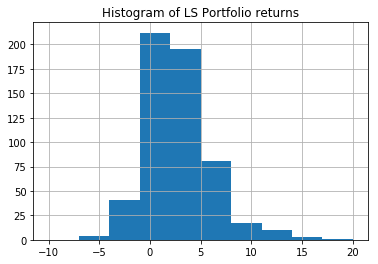

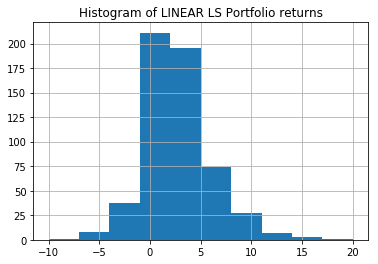

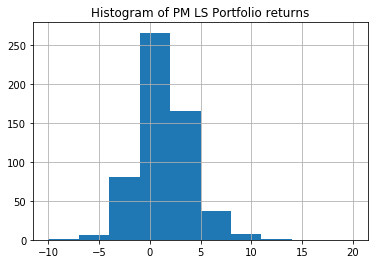

In [126]:
########## plot histogram of realized portfolio returns ##########

plt.figure(figsize=(20,10))
periodR.hist(range = (-10, 20))
plt.title("Histogram of LS Portfolio returns")
plt.show()

periodRLin.hist(range = (-10, 20))
plt.title("Histogram of LINEAR LS Portfolio returns")

periodRPM.hist(range = (-10, 20))
plt.title("Histogram of PM LS Portfolio returns")
plt.show()

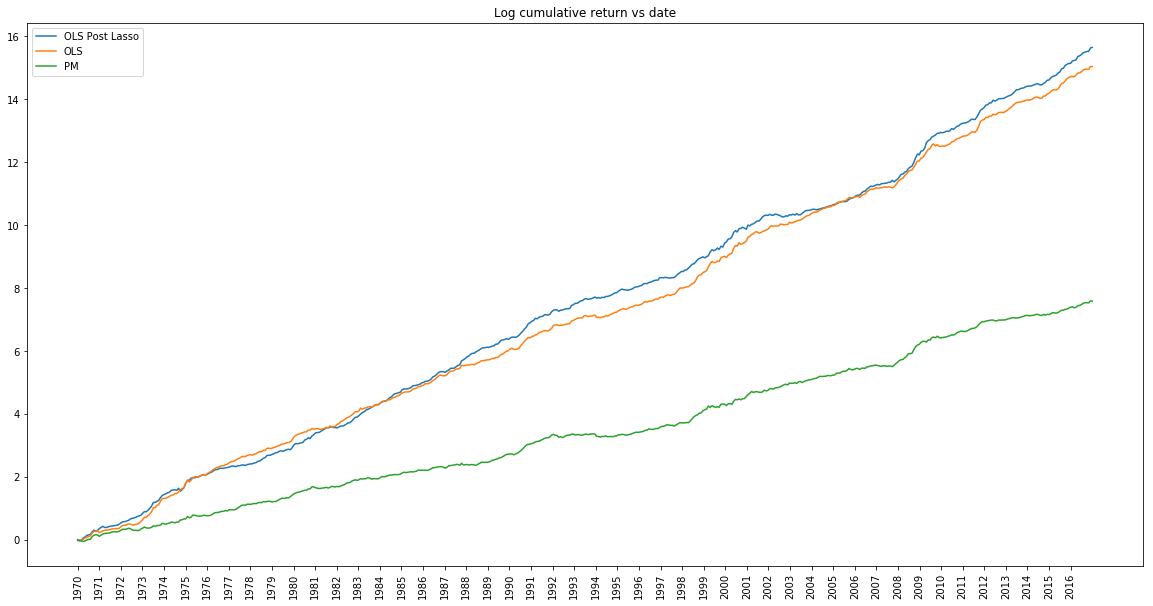

In [115]:
########## plot log cumulative return (figure 3 in paper) ##########
plt.figure(figsize = (20,10))
t = np.linspace(0, len(periodR["r"]), len(periodR["r"]))

logcumR = np.log((1 + periodR["r"]/100).cumprod()) 
plt.plot(t, logcumR, label = "OLS Post Lasso")

logcumRLin = np.log((1 + periodRLin["r"]/100).cumprod()) 
plt.plot(t, logcumRLin, label = "OLS")

logcumRPM = np.log((1 + periodRPM["r"]/100).cumprod()) 
plt.plot(t, logcumRPM, label = "PM")

plt.title("Log cumulative return vs date")
plt.legend()
x = periodR.index
plt.xticks(np.arange(len(x), step=12), x.asfreq("A").unique(), rotation = "vertical")
plt.show()



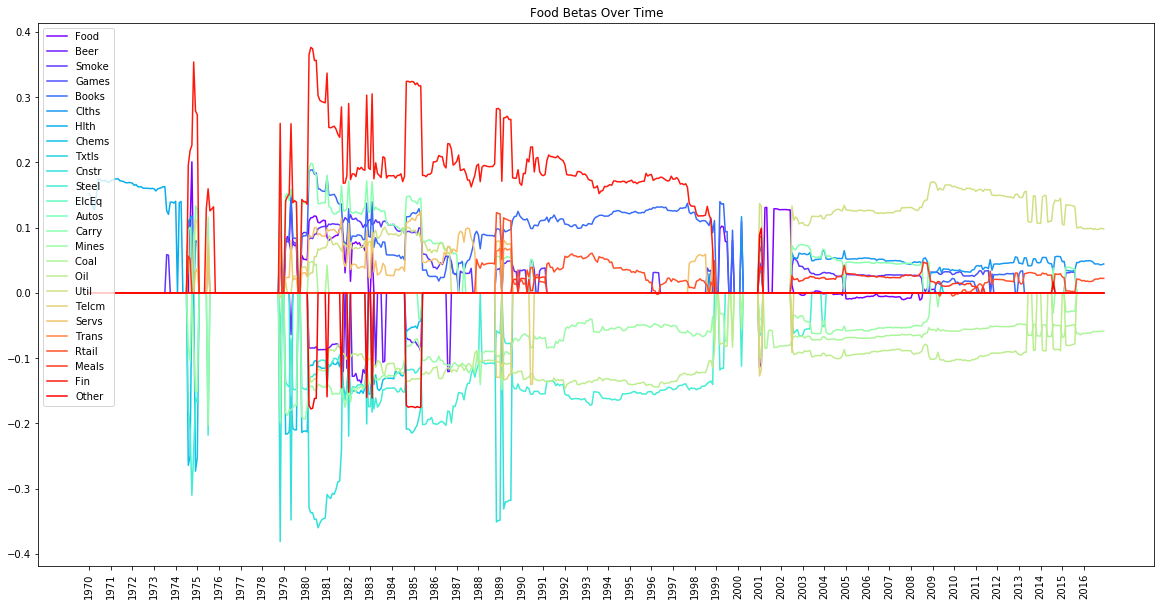

In [127]:
########## plot betas for food industry ########## 

plt.figure(figsize=(20,10))
(x, y) = indBeta.index, indBeta
xlab = "Date"
ylab = "OLS post Lasso Coefficiets"
title = indNames[ind] + "Betas Over Time"
xnew = range(len(x)) # equally spaced
colors = cm.rainbow(np.linspace(0, 1, len(list(y))))
for i in range(len(list(y))):
    if (len(np.nonzero(y.iloc[:, i])[0]) == 0): # industry not used at all
        plt.plot(xnew, y.iloc[:, i], label = "_nolegend_", color = colors[i])
    else:
        plt.plot(xnew, y.iloc[:, i], label = list(y)[i], color= colors[i])
plt.legend(fontsize = "medium", loc=2)

plt.title(title)
plt.xticks(np.arange(len(x), step=12), x.asfreq("A").unique(), rotation = "vertical")
plt.show()

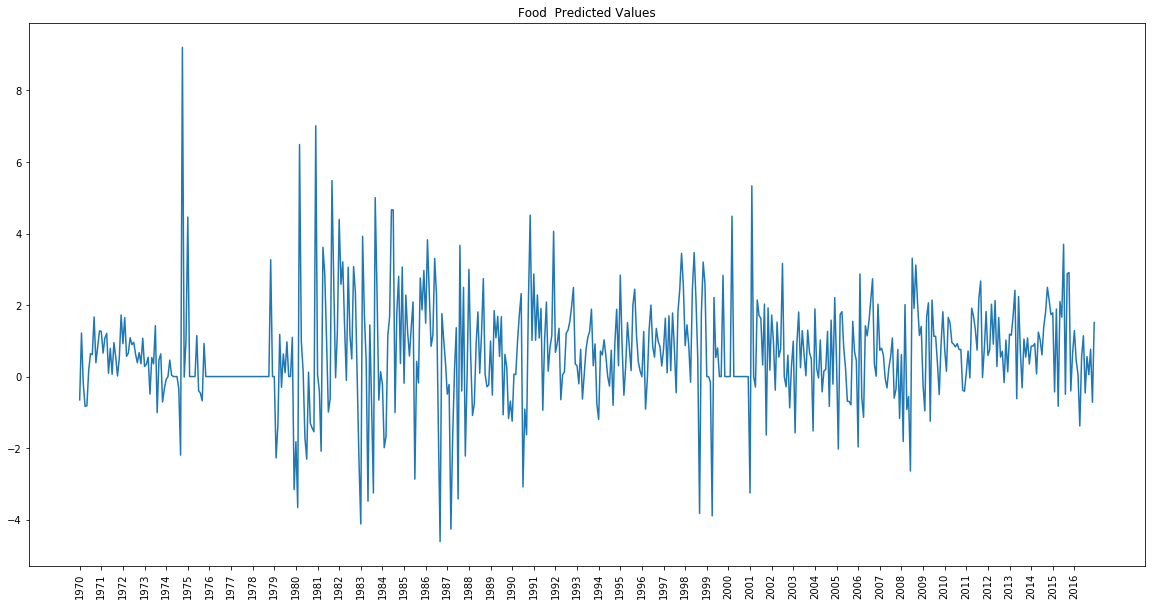

In [128]:
#plot predicted values for food industry
plt.figure(figsize=(20,10))
plt.plot(xnew, allIndPred.iloc[:, ind])
plt.title(indNames[ind] + " Predicted Values")
plt.xticks(np.arange(len(allIndPred.index), step=12), x.asfreq("A").unique(), rotation = "vertical")
plt.show()